In [1]:
%load_ext autoreload
%autoreload
%matplotlib widget
import importlib
from SOAEpeaks import load_df
import phaseco as pc
from phaseco import *
from tqdm import tqdm
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.signal.windows import gaussian
importlib.reload(pc)


<module 'phaseco' from 'c:\\Users\\Owner\\OneDrive\\Documents\\GitHub\\phase-coherence\\phaseco\\__init__.py'>

In [2]:


# Get different species
df = load_df(laptop=True, dfs_to_load=["Curated Data"])
wf_list = []
for species in ['Anolis', 'Owl', 'Human']:
    df_species = df[df['species'] == species]
    for i in range (3):
        row = df_species.iloc[i]
        wf_title = row['filepath'].split('\\')[-1]
        wf_list.append((row['wf'], row['sr'], wf_title, species))
del df

Loading Curated Data
Combining into one Dataframe!


In [30]:
wf_idx = 7 # Started with 0, 2 (Lizard) and 6, 7 (Human)

wf, fs, wf_title, species = wf_list[wf_idx]

# Set parameters (same for human and lizard)
tauS = 2**12
tau = tauS / 44100 # Everyone uses the same tau
rho = 0.7

if species == 'Human':
    # Human parameters
    min_xi = 0.001
    max_xi = 1
    delta_xi = 0.001
    if wf_title == 'human_TH14RearwaveformSOAE.mat':
        max_xi = 2.5
elif species in ['Lizard', 'Anolis']:
    # Lizard parameters
    min_xi = 0.001
    max_xi = 0.1
    delta_xi = 0.0005

In [31]:
# Calculate colossogram 
if 0:
    num_xis = int((max_xi - min_xi) / delta_xi) + 1
    xis = np.linspace(min_xi, max_xi, num_xis)

    max_xiS = max(xis) * fs
    f = rfftfreq(tauS, 1/fs)
    # Make sure we have a consistent number of segments to take vector strenght over since this will change with xi
    N_segs = int((len(wf) - tauS) / max_xiS)    

    coherences = np.zeros((len(f), len(xis)))
    print(f"Calculating coherence for wf {wf_title} with {len(xis)} xi values")
    for i, xi in enumerate(tqdm(xis)):
        coherences[:, i] = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", N_segs=N_segs, rho=rho)[1]

In [32]:
# Save/open coherences
operation = 'open'


suptitle=rf"[{wf_title}]   [$\rho$={rho}]   [$\tau$={tau*1000:.2f}ms]" 
fn_id = rf"tau={tau*1000:.0f}, rho={rho}, {species}, {wf_title.split('.')[0]}"
pkl_fn = f'C_xi Decay Coherences - {fn_id}'
pkl_folder = r'Pickles/'
fig_folder = r'Colossogram Figures/C_xi Decay Figures/'

if operation == 'save':
    with open(pkl_folder + pkl_fn + '.pkl', 'wb') as file:
        pickle.dump((coherences, f, xis, tau, rho, wf_title, species), file)
elif operation == 'open':
    with open(pkl_folder + pkl_fn + '.pkl', 'rb') as file:
        coherences, f, xis, tau, rho, wf_title, species = pickle.load(file)

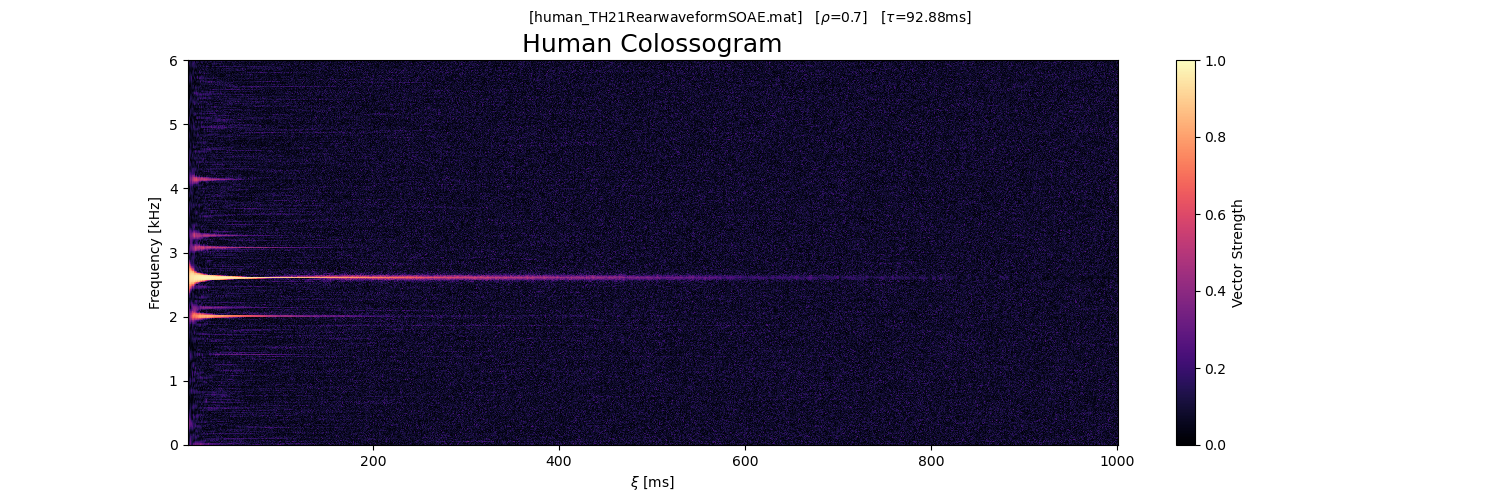

In [33]:
# Visualize colossogram
plt.close('all')
plt.figure(figsize=(15, 5))
max_khz = 6
plot_colossogram(coherences, f, xis, tau, max_khz=max_khz, cmap='magma')
plt.title(f"{species} Colossogram", fontsize=18)
plt.suptitle(suptitle, fontsize=10)
plt.savefig(f'{fig_folder}C_xi Colossogram - {fn_id}.png', dpi=300)
plt.show()

In [34]:
# Plot a slice of the colossogram with target bins marked
target_xi = 0.02
xi_idx = np.argmin(np.abs(xis - target_xi))
coherence_slice = coherences[:, xi_idx]
psd = get_welch(wf=wf, fs=fs, tauS=tauS)[1]
# psd_xi = get_welch(wf=wf, fs=fs, tauS=tauS, xi=target_xi)[1]

In [35]:
print(wf_title)

human_TH21RearwaveformSOAE.mat


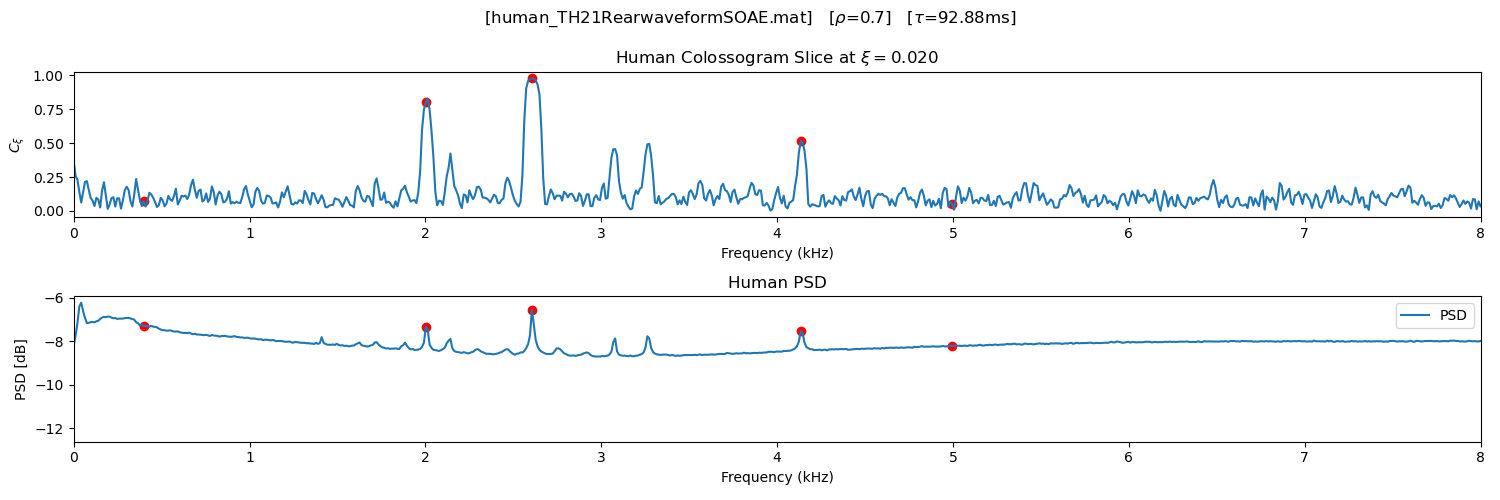

In [36]:
# Cont
if wf_title == 'anole_AC6rearSOAEwfB1.mat': # 0
    peak_freqs = [1225, 2150, 4300]
    noise_freqs = [400, 5000]
elif wf_title == 'anole_ACsb18learSOAEwfG4.mat': # 2
    peak_freqs = [990, 2000, 3670]
    noise_freqs = [400, 5000]
elif wf_title == 'human_TH14RearwaveformSOAE.mat': # 6
    peak_freqs = [603, 2250, 4370]
    noise_freqs = [400, 5000]
elif wf_title == 'human_TH21RearwaveformSOAE.mat': # 7
    peak_freqs = [2000, 2605, 4135]
    noise_freqs = [400, 5000]
else:
    raise("Haven't peak picked this waveform yet!")
    

bin_idxs = []
bin_names = []

for peak_freq in peak_freqs:
    bin_idxs.append(np.argmin(np.abs(f - peak_freq)))
    bin_names.append(f"{peak_freq:.0f}Hz Peak")

for noise_freq in noise_freqs:
    bin_idxs.append(np.argmin(np.abs(f - noise_freq)))
    bin_names.append(f"{noise_freq:.0f}Hz Noise")
    
freq_list = peak_freqs + noise_freqs
plt.close('all')
plt.figure(figsize=(15, 5))
plt.suptitle(suptitle)
plt.subplot(2, 1, 1)
plt.title(rf"{species} Colossogram Slice at $\xi={xis[xi_idx]:.3f}$")
plt.plot(f / 1000, coherence_slice)
for freq, idx in zip(freq_list, bin_idxs):
    plt.scatter(f[idx] / 1000, coherence_slice[idx], c='r')
plt.xlabel("Frequency (kHz)")
plt.ylabel(r'$C_{\xi}$')
plt.xlim(0, 8)
plt.subplot(2, 1, 2)
plt.title(rf"{species} PSD")
plt.plot(f / 1000, np.log10(psd), label='PSD')
#plt.plot(f / 1000, np.log10(psd_xi), label=r'PSD ($\xi$)')
for freq, idx in zip(freq_list, bin_idxs):
    plt.scatter(f[idx] / 1000, np.log10(psd[idx]), c='r')
    #plt.scatter(f[idx] / 1000, np.log10(psd_xi[idx]), c='r')
plt.xlabel("Frequency (kHz)")
plt.ylabel("PSD [dB]")  
plt.legend()
plt.xlim(0, 8)
plt.tight_layout()
plt.savefig(f'{fig_folder}C_xi Decay Target Bins - {fn_id}.png', dpi=300)
plt.show()

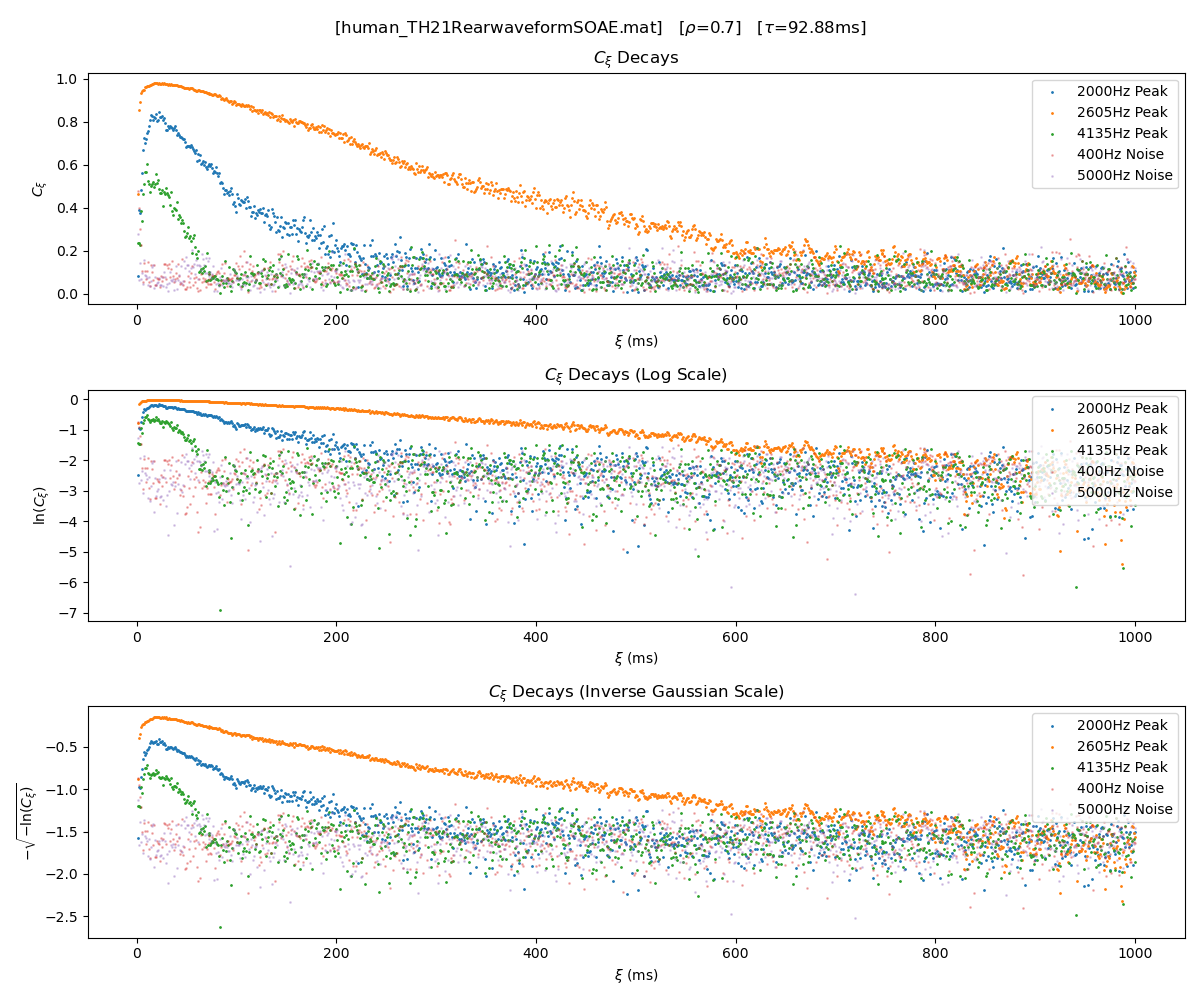

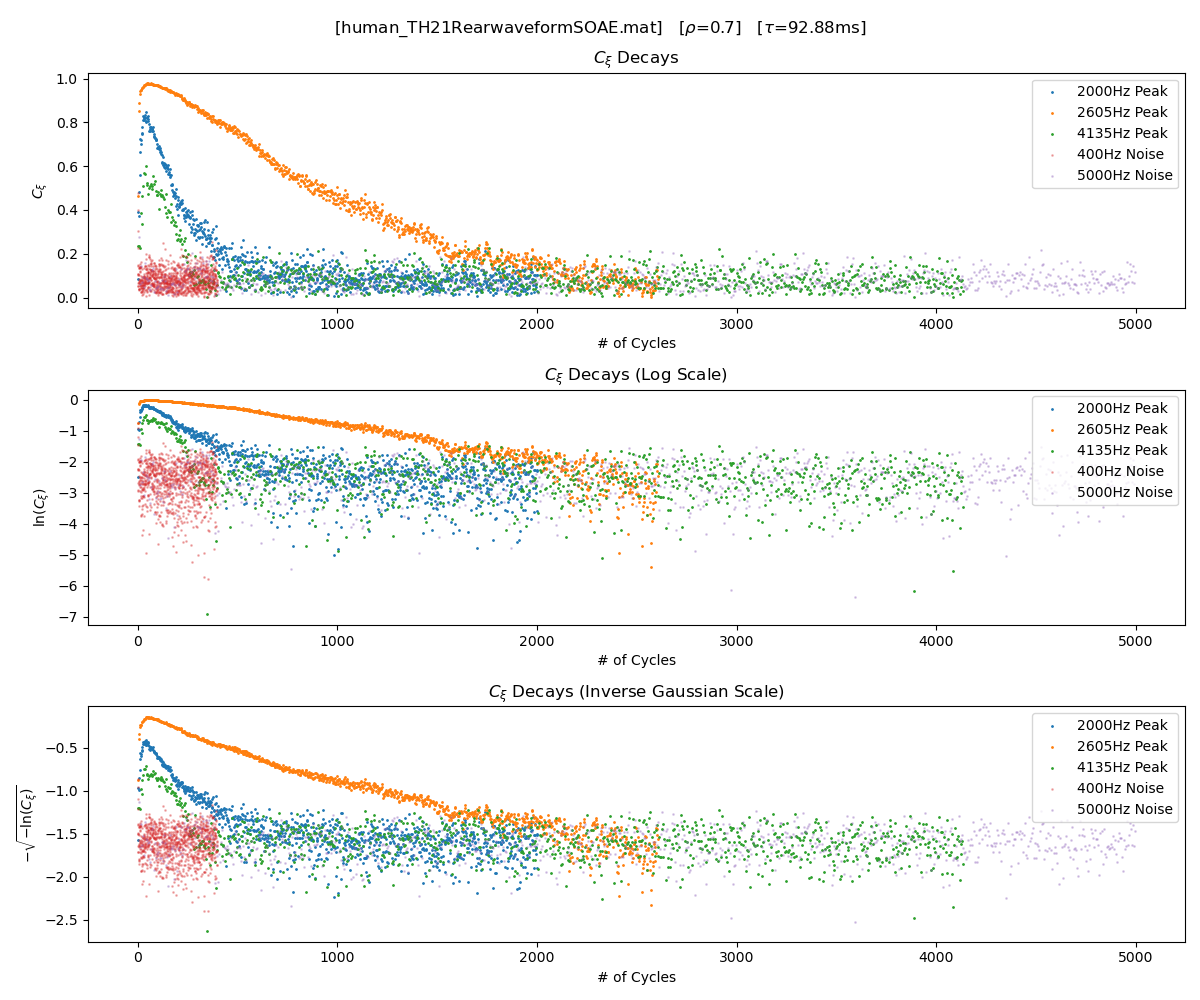

In [37]:

# Plot decays on various scales

s=1

for xscale_str in ['Xi', '# Cycles']:
    plt.figure(figsize=(12, 10))
    plt.suptitle(suptitle)
    for scale, idx in zip(['normal', 'log', 'gauss'], [1, 2, 3]):
        plt.subplot(3, 1, idx)
        for f_idx, bin_name in zip(bin_idxs, bin_names):
            coherence_falloff = coherences[f_idx, :]
            title = r"$C_{\xi}$ Decays"
            if scale == 'normal':
                plt.ylabel(r'$C_{\xi}$')
            if scale == 'gauss':
                coherence_falloff = -np.sqrt(-np.log(coherence_falloff))
                plt.ylabel(r'$-\sqrt{-\ln(C_{\xi})}$')
                title+= " (Inverse Gaussian Scale)"
            elif scale == 'log':
                coherence_falloff = np.log(coherence_falloff)
                plt.ylabel(r'$\ln(C_{\xi})$')
                plt.title("Log Scale")
                title+= " (Log Scale)"            
            plt.title(title)
            alpha=1
            if 'Noise' in bin_name:
                alpha=0.3
            if xscale_str == '# Cycles':
                x = xis * f[f_idx] # Nondimensionalize
                xlabel = '# of Cycles'
            else:
                x = xis*1000
                xlabel = r'$\xi$ (ms)'
            plt.scatter(x, coherence_falloff, label=bin_name, alpha=alpha, s=s)
        plt.xlabel(xlabel)
        plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(f'{fig_folder}C_xi Decay Scales - {xscale_str} - {fn_id}.png', dpi=300)
    plt.show()


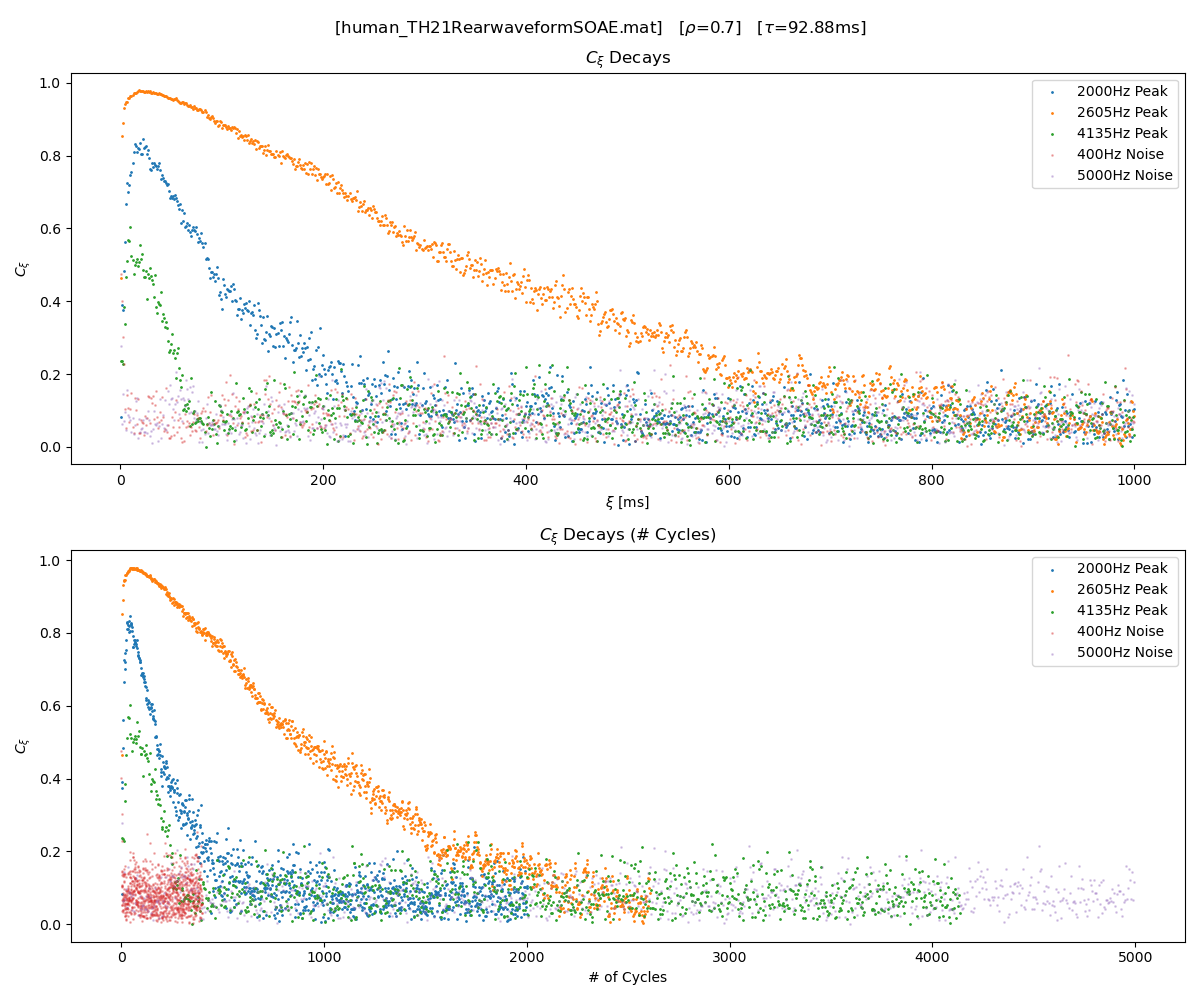

In [38]:
# Compare xi scale vs # cycles scale
plt.figure(figsize=(12, 10))
plt.suptitle(suptitle)

# Xi scale
plt.subplot(2, 1, 1)
title = r"$C_{\xi}$ Decays"
for f_idx, bin_name in zip(bin_idxs, bin_names):
    coherence_falloff = coherences[f_idx, :]    
    plt.ylabel(r'$C_{\xi}$')           
    plt.title(title)
    alpha=1
    if 'Noise' in bin_name:
        alpha=0.3
    plt.scatter(xis*1000, coherence_falloff, label=bin_name, alpha=alpha, s=s)
plt.xlabel(r'$\xi$ [ms]')
plt.legend()

# Num Cycles scale
plt.subplot(2, 1, 2)
title = r"$C_{\xi}$ Decays (# Cycles)"
for f_idx, bin_name in zip(bin_idxs, bin_names):
    coherence_falloff = coherences[f_idx, :]
 
    nums_cycles = xis * f[f_idx] # Nondimensionalize
    plt.ylabel(r'$C_{\xi}$')           
    plt.title(title)
    alpha=1
    if 'Noise' in bin_name:
        alpha=0.3
    plt.scatter(nums_cycles, coherence_falloff, label=bin_name, alpha=alpha, s=s)
plt.xlabel(r'# of Cycles')
plt.legend()

# Book it!
plt.tight_layout()
plt.savefig(f'{fig_folder}C_xi Decays Xi vs # Cycles - {fn_id}.png', dpi=300)
plt.show()
    

